# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 4

In [2]:
%reload_ext autoreload
%autoreload 2

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, random_split, SubsetRandomSampler, DataLoader, WeightedRandomSampler

from torchvision.transforms.v2 import ToImage, ToDtype, Compose, ToPILImage, RandomHorizontalFlip, Normalize

In [75]:
from data_generation.image_classification import generate_dataset
from stepbystep.v0 import StepByStep
from plots.chapter4 import plot_images, image_channels, figure5, weights_comparison, figure7, plot_activation

In [ ]:
plt.style.use('fivethirtyeight')
%matplotlib inline

# Classifying Images

## Data Generation

In [7]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

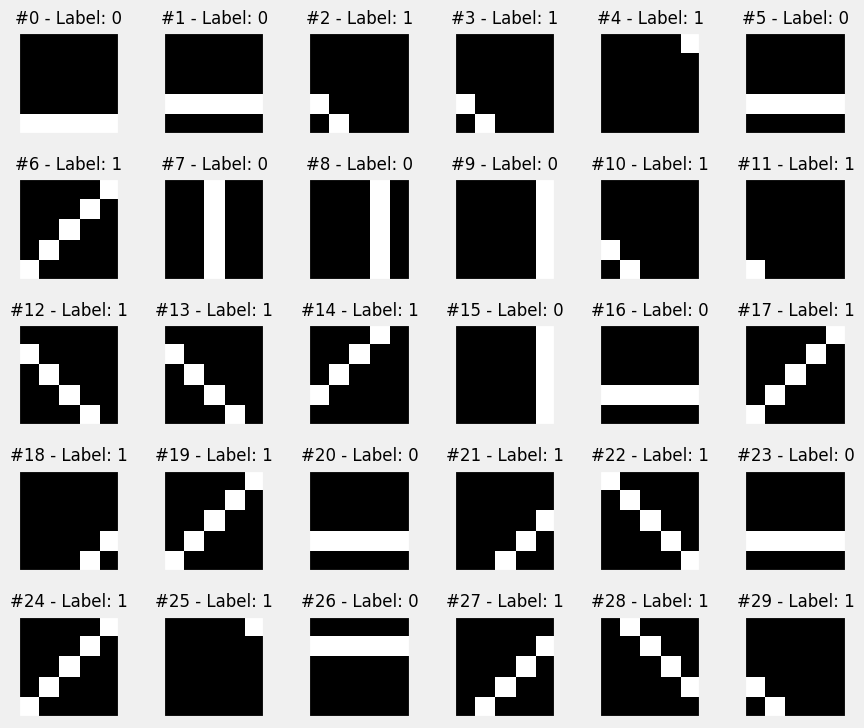

In [17]:
fig = plot_images(images, labels, n_plot=30)

## Images and Channels

In [5]:
image_r = np.zeros((5, 5), dtype=np.uint8)
image_r[:, 0] = 255
image_r[:, 1] = 128

image_g = np.zeros((5, 5), dtype=np.uint8)
image_g[:, 1] = 128
image_g[:, 2] = 255
image_g[:, 3] = 128

image_b = np.zeros((5, 5), dtype=np.uint8)
image_b[:, 3] = 128
image_b[:, 4] = 255

In [6]:
image_r, image_g, image_b

(array([[255, 128,   0,   0,   0],
        [255, 128,   0,   0,   0],
        [255, 128,   0,   0,   0],
        [255, 128,   0,   0,   0],
        [255, 128,   0,   0,   0]], dtype=uint8),
 array([[  0, 128, 255, 128,   0],
        [  0, 128, 255, 128,   0],
        [  0, 128, 255, 128,   0],
        [  0, 128, 255, 128,   0],
        [  0, 128, 255, 128,   0]], dtype=uint8),
 array([[  0,   0,   0, 128, 255],
        [  0,   0,   0, 128, 255],
        [  0,   0,   0, 128, 255],
        [  0,   0,   0, 128, 255],
        [  0,   0,   0, 128, 255]], dtype=uint8))

In [7]:
image_rgb = np.stack([image_r, image_g, image_b], axis=2)
image_rgb

array([[[255,   0,   0],
        [128, 128,   0],
        [  0, 255,   0],
        [  0, 128, 128],
        [  0,   0, 255]],

       [[255,   0,   0],
        [128, 128,   0],
        [  0, 255,   0],
        [  0, 128, 128],
        [  0,   0, 255]],

       [[255,   0,   0],
        [128, 128,   0],
        [  0, 255,   0],
        [  0, 128, 128],
        [  0,   0, 255]],

       [[255,   0,   0],
        [128, 128,   0],
        [  0, 255,   0],
        [  0, 128, 128],
        [  0,   0, 255]],

       [[255,   0,   0],
        [128, 128,   0],
        [  0, 255,   0],
        [  0, 128, 128],
        [  0,   0, 255]]], dtype=uint8)

[]

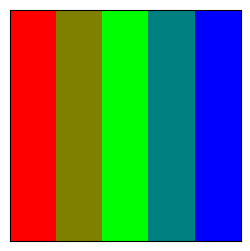

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(image_rgb)
ax.set_xticks([])
ax.set_yticks([])

In [12]:
stacked_on_axis1 = np.stack([image_r, image_g, image_b], axis=1)
stacked_on_axis1

array([[[255, 128,   0,   0,   0],
        [  0, 128, 255, 128,   0],
        [  0,   0,   0, 128, 255]],

       [[255, 128,   0,   0,   0],
        [  0, 128, 255, 128,   0],
        [  0,   0,   0, 128, 255]],

       [[255, 128,   0,   0,   0],
        [  0, 128, 255, 128,   0],
        [  0,   0,   0, 128, 255]],

       [[255, 128,   0,   0,   0],
        [  0, 128, 255, 128,   0],
        [  0,   0,   0, 128, 255]],

       [[255, 128,   0,   0,   0],
        [  0, 128, 255, 128,   0],
        [  0,   0,   0, 128, 255]]], dtype=uint8)

TypeError: Invalid shape (5, 3, 5) for image data

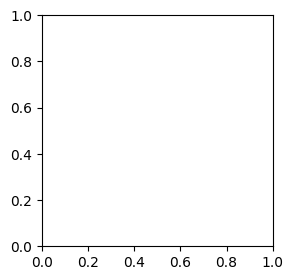

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(stacked_on_axis1)
ax.set_xticks([])
ax.set_yticks([])

In [32]:
image_gray = (.2126 * image_r + .7152 * image_g + .0722 * image_b).astype(np.uint8)
image_gray

array([[ 54, 118, 182, 100,  18],
       [ 54, 118, 182, 100,  18],
       [ 54, 118, 182, 100,  18],
       [ 54, 118, 182, 100,  18],
       [ 54, 118, 182, 100,  18]], dtype=uint8)

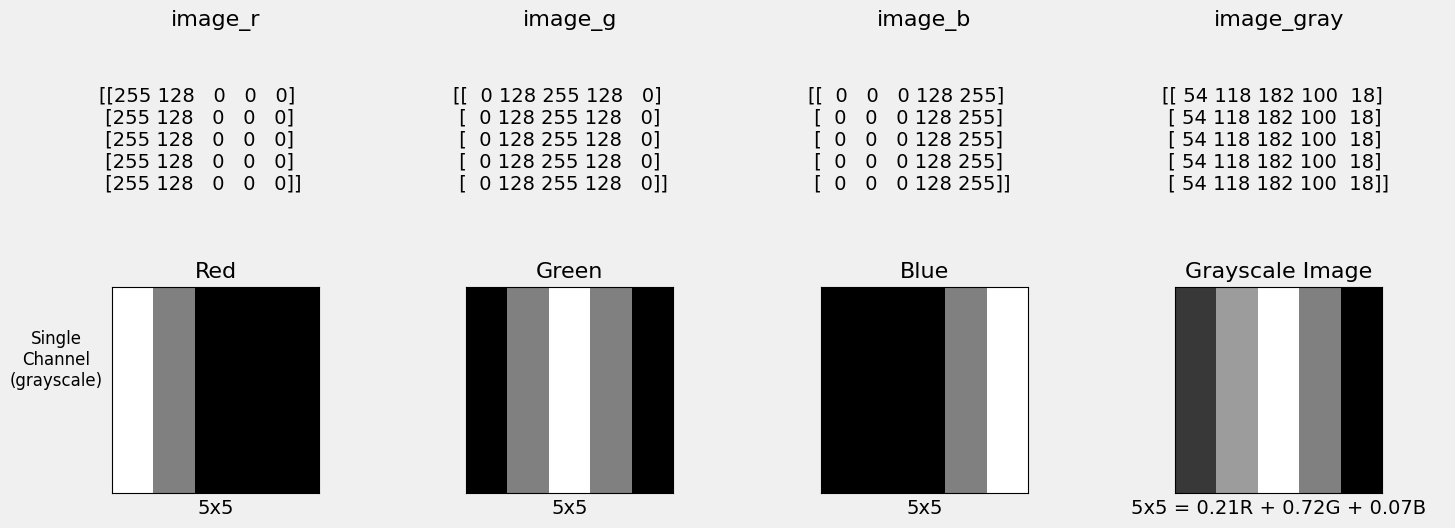

In [48]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 1))

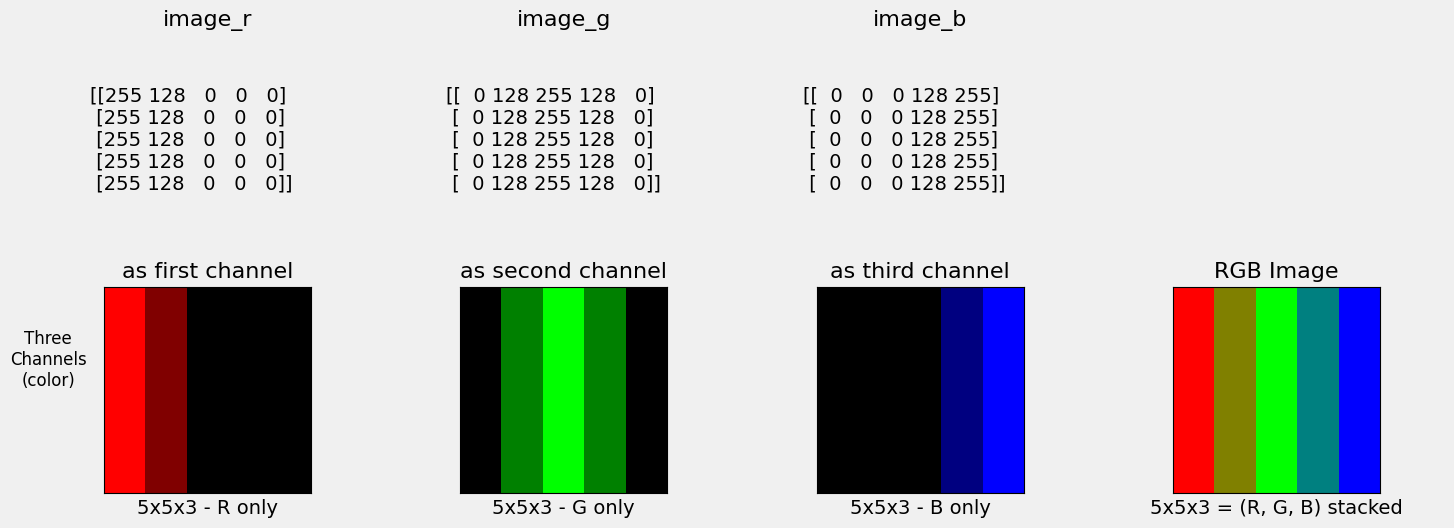

In [49]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 2))

### NCHW vs NHWC

In [50]:
images.shape

(300, 1, 5, 5)

In [69]:
example = images[12]
example

array([[[  0,   0,   0,   0,   0],
        [255,   0,   0,   0,   0],
        [  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0]]], dtype=uint8)

In [70]:
example_hwc = np.transpose(example, (1, 2, 0))
example_hwc.shape

(5, 5, 1)

In [71]:
example_hwc

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[255],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [255],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [255],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [255],
        [  0]]], dtype=uint8)

## Torchvision

### Transforms

In [72]:
image_tensor = ToImage()(example_hwc)
image_tensor, image_tensor.shape

(Image([[[  0,   0,   0,   0,   0],
         [255,   0,   0,   0,   0],
         [  0, 255,   0,   0,   0],
         [  0,   0, 255,   0,   0],
         [  0,   0,   0, 255,   0]]], dtype=torch.uint8, ),
 torch.Size([1, 5, 5]))

In [56]:
isinstance(image_tensor, torch.Tensor)

True

In [73]:
example_tensor = ToDtype(torch.float32, scale=True)(image_tensor)
example_tensor

Image([[[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]]], )

In [74]:
def ToTensor():
    return Compose([ToImage(), ToDtype(torch.float32, scale=True)])

tensorizer = ToTensor()
example_tensor = tensorizer(example_hwc)
example_tensor

Image([[[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]]], )

In [75]:
example_img = ToPILImage()(example_tensor)
type(example_img)

PIL.Image.Image

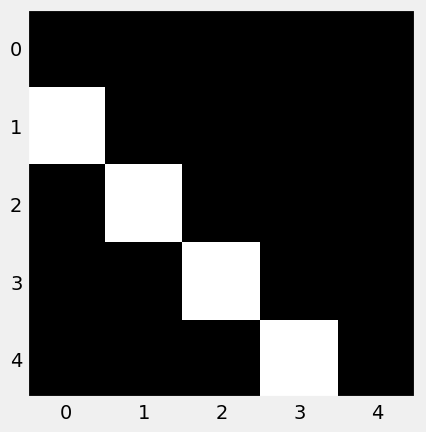

In [76]:
plt.imshow(example_img, cmap='gray')
plt.grid(False)

### Transforms on Images

In [81]:
flipper = RandomHorizontalFlip(p=1.0)
flipped_img = flipper(example_img)

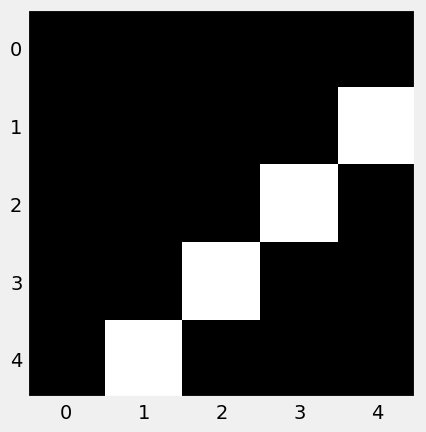

In [80]:
plt.imshow(flipped_img, cmap='gray')
plt.grid(False)

### Tensor-only Transforms

In [82]:
img_tensor = tensorizer(flipped_img)
img_tensor

Image([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]]], )

#### Normalize Transform

$$
\Large
\begin{aligned}
input = 0 \implies \frac{0 - mean}{std} = \frac{0 - 0.5}{0.5} &= -1
\\
\\
input = 1 \implies \frac{1 - mean}{std} = \frac{1 - 0.5}{0.5} &= 1
\end{aligned}
$$

In [84]:
normalizer = Normalize(mean=(.5,), std=(.5,))
normalized_tensor = normalizer(img_tensor)
normalized_tensor

Image([[[-1., -1., -1., -1., -1.],
        [-1., -1., -1., -1.,  1.],
        [-1., -1., -1.,  1., -1.],
        [-1., -1.,  1., -1., -1.],
        [-1.,  1., -1., -1., -1.]]], )

### Composing Transforms

In [85]:
composer = Compose([RandomHorizontalFlip(p=1.0),
                    Normalize(mean=(.5,), std=(.5,))])

In [87]:
composed_tensor = composer(example_tensor)
(composed_tensor == normalized_tensor).all()

tensor(True)

In [88]:
print(example)
print(example_tensor)

[[[  0   0   0   0   0]
  [255   0   0   0   0]
  [  0 255   0   0   0]
  [  0   0 255   0   0]
  [  0   0   0 255   0]]]
Image([[[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]]], )


In [89]:
example_tensor = torch.as_tensor(example / 255).float()

## Data Preparation

In [90]:
# Build tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

### Dataset Transforms

In [9]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]

        if self.transform:
            x = self.transform(x)

        return x, self.y[index]

    def __len__(self):
        return len(self.x)

In [93]:
composer = Compose([RandomHorizontalFlip(p=.5),
                    Normalize(mean=(.5,), std=(.5,))])

dataset = TransformedTensorDataset(x_tensor, y_tensor, transform=composer)

### SubsetRandomSampler

### Helper Function #4

In [10]:
def index_splitter(n, splits, seed=13):
    '''
    Parameters:
    n: The number of data points to generate indices for.
    splits: A list of values representing the relative weights of the split sizes.
    seed: A random seed to ensure reproducibility.
    '''

    idx = torch.arange(n)

    # Make the splits argument a tensor
    splits_tensor = torch.as_tensor(splits)
    total = splits_tensor.sum().float()

    # If the total does not add up to one, divide every number by the total.
    if not total.isclose(torch.tensor(1.)):
        splits_tensor = splits_tensor / total

    # Use PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

In [99]:
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
train_idx

In [100]:
train_idx.indices

[118,
 170,
 148,
 239,
 226,
 146,
 168,
 195,
 6,
 180,
 157,
 2,
 160,
 66,
 46,
 276,
 126,
 212,
 119,
 77,
 53,
 237,
 252,
 202,
 200,
 289,
 135,
 186,
 231,
 211,
 35,
 293,
 229,
 265,
 256,
 134,
 191,
 214,
 8,
 83,
 150,
 190,
 208,
 209,
 275,
 60,
 295,
 142,
 251,
 176,
 260,
 3,
 31,
 0,
 137,
 20,
 81,
 287,
 181,
 129,
 166,
 97,
 110,
 206,
 267,
 241,
 109,
 177,
 27,
 52,
 43,
 245,
 247,
 141,
 68,
 131,
 217,
 78,
 185,
 49,
 96,
 14,
 111,
 234,
 284,
 263,
 269,
 101,
 32,
 285,
 79,
 297,
 94,
 85,
 11,
 5,
 80,
 165,
 183,
 4,
 33,
 100,
 73,
 235,
 277,
 16,
 144,
 132,
 167,
 130,
 45,
 48,
 201,
 99,
 34,
 138,
 178,
 244,
 225,
 173,
 95,
 22,
 197,
 174,
 90,
 223,
 274,
 92,
 279,
 19,
 74,
 28,
 162,
 133,
 151,
 37,
 299,
 18,
 203,
 13,
 156,
 268,
 259,
 116,
 70,
 71,
 230,
 108,
 238,
 47,
 163,
 30,
 188,
 64,
 216,
 121,
 187,
 72,
 221,
 258,
 44,
 179,
 272,
 159,
 253,
 280,
 140,
 120,
 62,
 271,
 57,
 1,
 149,
 9,
 29,
 194,
 158,
 115,
 1

In [102]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [104]:
train_loader = DataLoader(dataset=dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=dataset, batch_size=16, sampler=val_sampler)

In [105]:
len(iter(train_loader)), len(iter(val_loader))

(15, 4)

### Data Augmentation Transformations

In [106]:
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]

x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

In [108]:
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

In [109]:
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### WeightedRandomSampler

In [111]:
classes, counts = y_train_tensor.unique(return_counts=True)
print(classes, counts)

tensor([0., 1.]) tensor([ 72, 168])


In [112]:
weights = 1. / counts.float()
weights

tensor([0.0139, 0.0060])

In [115]:
y_train_tensor.squeeze().long()

tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [114]:
sample_weights = weights[y_train_tensor.squeeze().long()]
sample_weights

tensor([0.0060, 0.0060, 0.0139, 0.0139, 0.0060, 0.0139, 0.0060, 0.0060, 0.0060,
        0.0139, 0.0139, 0.0060, 0.0139, 0.0060, 0.0060, 0.0060, 0.0060, 0.0139,
        0.0060, 0.0060, 0.0060, 0.0060, 0.0139, 0.0139, 0.0060, 0.0139, 0.0139,
        0.0060, 0.0139, 0.0060, 0.0139, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060,
        0.0060, 0.0060, 0.0139, 0.0060, 0.0060, 0.0060, 0.0060, 0.0139, 0.0060,
        0.0060, 0.0139, 0.0139, 0.0060, 0.0060, 0.0139, 0.0060, 0.0060, 0.0139,
        0.0060, 0.0139, 0.0060, 0.0060, 0.0060, 0.0139, 0.0139, 0.0060, 0.0139,
        0.0060, 0.0060, 0.0139, 0.0139, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060,
        0.0060, 0.0060, 0.0060, 0.0060, 0.0139, 0.0139, 0.0060, 0.0060, 0.0060,
        0.0060, 0.0060, 0.0060, 0.0139, 0.0060, 0.0060, 0.0139, 0.0139, 0.0060,
        0.0060, 0.0060, 0.0060, 0.0139, 0.0060, 0.0139, 0.0139, 0.0139, 0.0060,
        0.0060, 0.0060, 0.0139, 0.0139, 0.0060, 0.0060, 0.0139, 0.0139, 0.0060,
        0.0060, 0.0060, 0.0060, 0.0060, 

In [117]:
generator = torch.Generator()

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    generator=generator,
    replacement=True
)

In [118]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### Helper Function #5

In [11]:
def make_balanced_sampler(y):
    # Compute weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1. / counts.float()
    sample_weights = weights[y.squeeze().long()]

    generator = torch.Generator()

    # Build the weighted sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )

    return sampler

In [120]:
sampler = make_balanced_sampler(y_train_tensor)

### Seeds and more (seeds)

In [122]:
train_loader.sampler.generator.manual_seed(42)

In [125]:
torch.tensor([t[1].sum() for t in iter(train_loader)]).sum()

tensor(121.)

### Putting It Together

In [12]:
# Build tensors from numpy arrays BEFORE split
# Modify the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Use index_splitter to generate indices for training and validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])

# Use indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Build different composers because of data augmentation on training set
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Use custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Build a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Use sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### Pixels as Features

In [13]:
dummy_xs, dummy_ys = next(iter(train_loader))
dummy_xs.shape

torch.Size([16, 1, 5, 5])

In [16]:
flattener = nn.Flatten()
dummy_xs_flat = flattener(dummy_xs)

print(dummy_xs_flat.shape)
print(dummy_xs_flat[0])

torch.Size([16, 25])
tensor([-1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1.,
        -1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1.])


## Shallow Model

$$
\Large P(y=1) = \sigma(z) = \sigma(w_0x_0 + w_1x_1 + \cdots + w_24x_24)
$$

![](images/classification.png)

### Notation

$$
\Large W = 
\underset{(25 \times 1)}{
    \begin{bmatrix}
    w_0 \\
    w_1 \\
    \vdots \\
    w_{24}
    \end{bmatrix}
};
X = 
\underset{(25 \times 1)}{
    \begin{bmatrix}
    x_0 \\
    x_1 \\
    \vdots \\
    x_{24}
    \end{bmatrix}
}
$$

$$
\Large
\begin{aligned}
z & = W^T \cdot X = 
\underset{(1 \times 25)}{
    \begin{bmatrix}
    - & w^T & -
    \end{bmatrix}
}
\underset{25 \times 1}{
    \begin{bmatrix}
    x_0 \\
    x_1 \\
    \vdots \\
    x_{24}
    \end{bmatrix}
}
=
\underset{(1 \times 25)}{
    \begin{bmatrix}
    w_0 & w_1 & \cdots & w_{24}
    \end{bmatrix}
}
\underset{25 \times 1}{
    \begin{bmatrix}
    x_0 \\
    x_1 \\
    \vdots \\
    x_{24}
    \end{bmatrix}
}
\\
& = w_0x_0 + w_1x_1 + \cdots + w_{24}x_{24}
\end{aligned}
$$

### Model Configuration

In [38]:
# Learning rate
lr = .1

torch.manual_seed(17)

# Create a model
model_logistic = nn.Sequential()
model_logistic.add_module('flatten', nn.Flatten())
model_logistic.add_module('output', nn.Linear(25, 1, bias=False))
model_logistic.add_module('sigmoid', nn.Sigmoid())

# Define a SGD optimizer to update the parameters
optimizer_logistic = optim.SGD(model_logistic.parameters(), lr=lr)

# Define a binary cross entropy loss function
bce_loss_fn = nn.BCELoss()

### Model Training

In [39]:
n_epochs = 100

sbs_logistic = StepByStep(model_logistic, bce_loss_fn, optimizer_logistic)
sbs_logistic.set_loaders(train_loader, val_loader)
sbs_logistic.train(n_epochs)

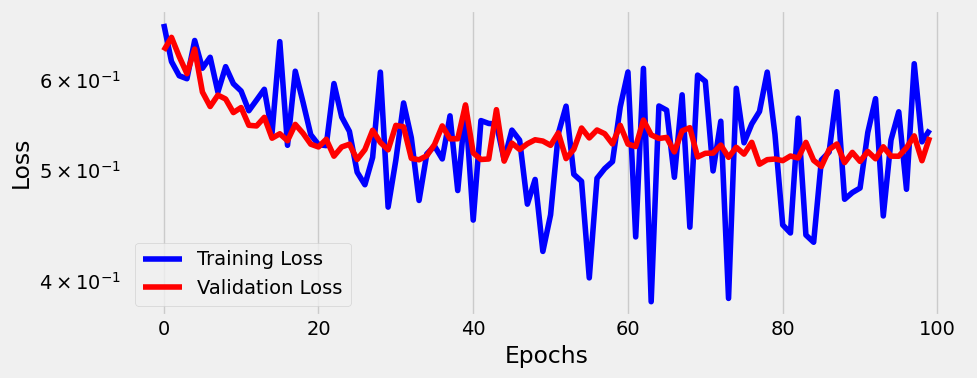

In [19]:
fig = sbs_logistic.plot_losses()

## Deep-ish Model

![](images/classification_equiv.png)

### Model Configuration

In [20]:
# Learning rate
lr = .1

torch.manual_seed(17)

# Creae a model
model_nn = nn.Sequential()
model_nn.add_module('flatten', nn.Flatten())
model_nn.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_nn.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_nn.add_module('output', nn.Linear(3, 1, bias=False))
model_nn.add_module('sigmoid', nn.Sigmoid())

# Define a SGD optimizer to update the parameters
optimizer_nn = optim.SGD(model_nn.parameters(), lr=lr)

# Define a binary cross entropy loss function
bce_loss_fn = nn.BCELoss()

### Model Training

In [21]:
n_epochs = 100

sbs_nn = StepByStep(model_nn, bce_loss_fn, optimizer_nn)
sbs_nn.set_loaders(train_loader, val_loader)
sbs_nn.train(n_epochs)

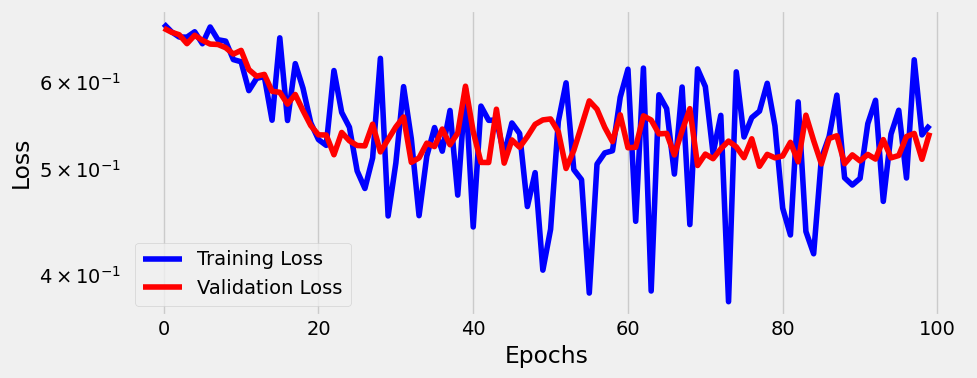

In [22]:
fig = sbs_nn.plot_losses()

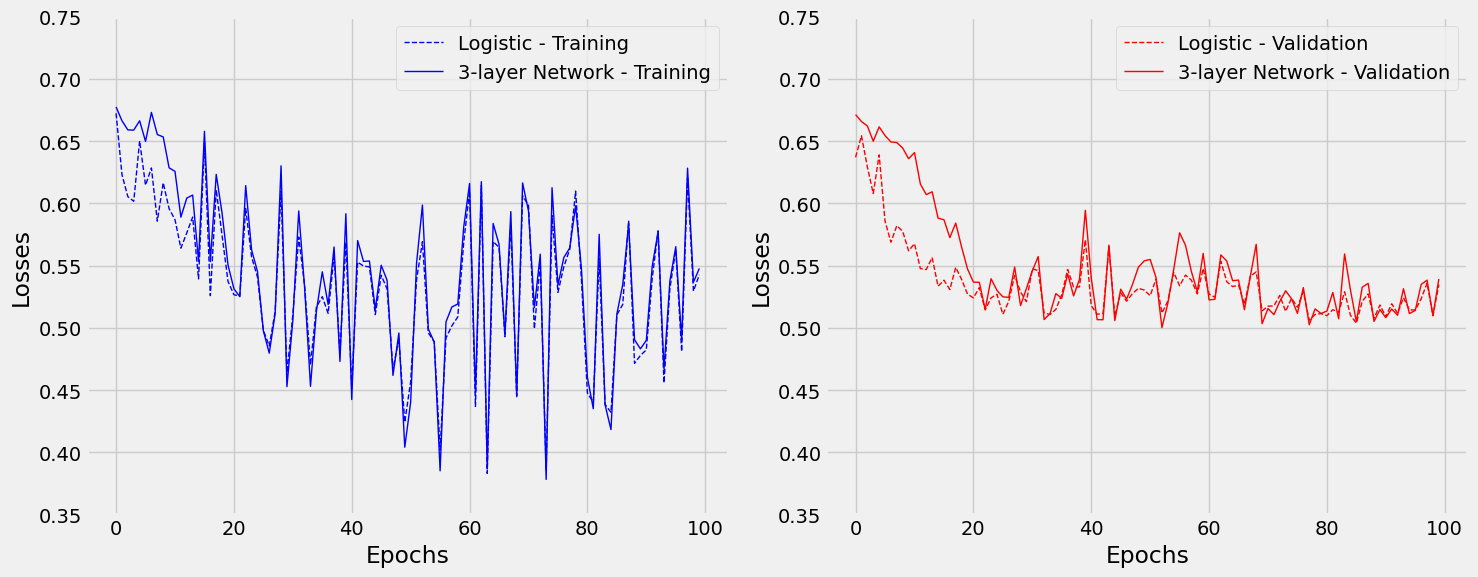

In [33]:
fig = figure5(sbs_logistic, sbs_nn)

$$
\#0
$$

### Show Me the Math!

$$
\begin{array}{rcccccccccccc}
\text{Hidden}\ \#0 & & & & & & & &
\underset{(5 \times 1)}{
    \begin{bmatrix}
    z_{00} \\
    z_{01} \\
    z_{02} \\
    z_{03} \\
    z_{04}
    \end{bmatrix}
}
& = &
\underset{(5 \times 25)}{
    \begin{bmatrix}
    - & w^{T}_{00} & - \\
    - & w^{T}_{01} & - \\
    - & w^{T}_{02} & - \\
    - & w^{T}_{03} & - \\
    - & w^{T}_{04} & -
    \end{bmatrix}
}
& &
\underset{(25 \times 1)}{
    \begin{bmatrix}
    x_0 \\
    \vdots \\
    x_{11} \\
    \vdots \\
    x_{24}
    \end{bmatrix}
}
\\
\text{Hidden}\ \#1 & & & &
\underset{(3 \times 1)}{
    \begin{bmatrix}
    z_{10} \\
    z_{11} \\
    z_{12}
    \end{bmatrix}
}
& = &
\underset{(3 \times 5)}{
    \begin{bmatrix}
    - & w^{T}_{10} & - \\
    - & w^{T}_{11} & - \\
    - & w^{T}_{12} & -
    \end{bmatrix}
}
& &
\underset{(5 \times 1)}{
    \begin{bmatrix}
    z_{00} \\
    z_{01} \\
    z_{02} \\
    z_{03} \\
    z_{04}
    \end{bmatrix}
}
\\
\text{Output} &
\underset{(1 \times 1)}{
    \begin{bmatrix}
    z_{2}
    \end{bmatrix}
}
& = &
\underset{(1 \times 3)}{
    \begin{bmatrix}
    - & w^{T}_{20} & -
    \end{bmatrix}
}
&
\underset{(3 \times 1)}{
    \begin{bmatrix}
    z_{10} \\
    z_{11} \\
    z_{12}
    \end{bmatrix}
}
\\
\hline
\text{substituting } z's... &
\underset{(1 \times 1)}{
    \begin{bmatrix}
    z_{2}
    \end{bmatrix}
}
& = &
\underbrace{
    \underset{(1 \times 3)}{
        \begin{bmatrix}
        - & w^{T}_{20} & -
        \end{bmatrix}
    }
}_{\text{Output Layer}}
& & &
\underbrace{
    \underset{(3 \times 5)}{
        \begin{bmatrix}
        - & w^{T}_{10} & - \\
        - & w^{T}_{11} & - \\
        - & w^{T}_{12} & -
        \end{bmatrix}
    }
}_{\text{Hidden Layer \#1}}
& & & &
\underbrace{
    \underset{(5 \times 25)}{
        \begin{bmatrix}
        - & w^{T}_{00} & - \\
        - & w^{T}_{01} & - \\
        - & w^{T}_{02} & - \\
        - & w^{T}_{03} & - \\
        - & w^{T}_{04} & -
        \end{bmatrix}
    }
}_{\text{Hidden Layer \#0}}
& &
\underset{(25 \times 1)}{
    \begin{bmatrix}
    x_0 \\
    \vdots \\
    x_{11} \\
    \vdots \\
    x_{24}
    \end{bmatrix}
}
\\
\text{multiplying...} & & = &
\underbrace{
    \underset{(1 \times 25)}{
        \begin{bmatrix}
        - & w^{T} & -
        \end{bmatrix}
    }
}_{\text{Matrices Multiplied}}
& & & & & & & & &
\underset{(25 \times 1)}{
    \begin{bmatrix}
    x_0 \\
    \vdots \\
    x_{11} \\
    \vdots \\
    x_{24}
    \end{bmatrix}
}
\end{array}
$$

### Show Me the Code!

In [34]:
w_nn_hidden0 = model_nn.hidden0.weight.detach()
w_nn_hidden1 = model_nn.hidden1.weight.detach()
w_nn_output = model_nn.output.weight.detach()

w_nn_hidden0.shape, w_nn_hidden1.shape, w_nn_output.shape

(torch.Size([5, 25]), torch.Size([3, 5]), torch.Size([1, 3]))

In [35]:
w_nn_equiv = w_nn_output @ w_nn_hidden1 @ w_nn_hidden0
w_nn_equiv.shape

torch.Size([1, 25])

In [36]:
w_nn_equiv = w_nn_output.mm(w_nn_hidden1.mm(w_nn_hidden0))

In [40]:
w_logistic_output = model_logistic.output.weight.detach()
w_logistic_output.shape

torch.Size([1, 25])

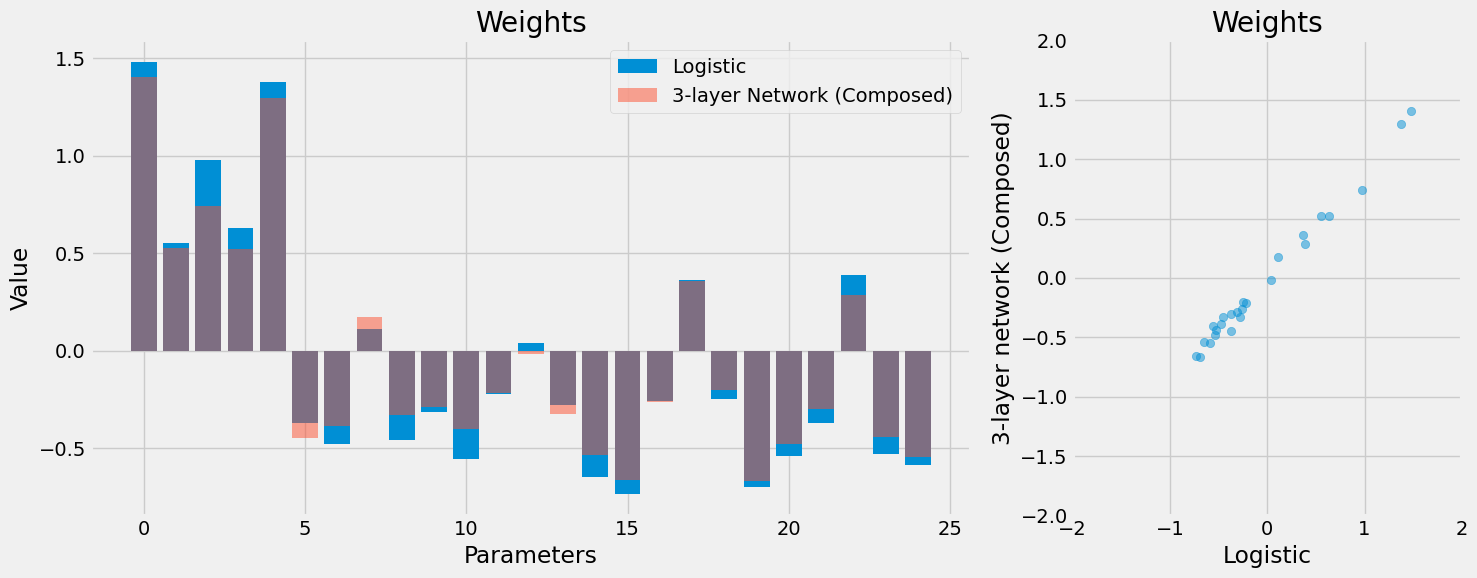

In [42]:
fig = weights_comparison(w_logistic_output, w_nn_equiv)

In [44]:
def count_parameters(self):
    return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

setattr(StepByStep, 'count_parameters', count_parameters)

In [45]:
sbs_logistic.count_parameters(), sbs_nn.count_parameters()

(25, 143)

### Weights as Pixels

In [46]:
w_nn_hidden0.shape

torch.Size([5, 25])

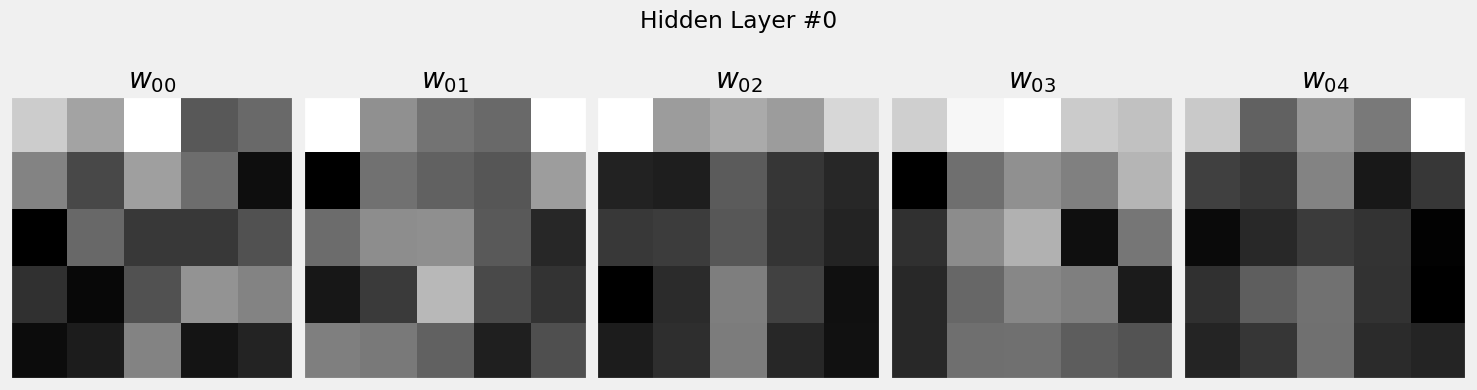

In [48]:
fig = figure7(w_nn_hidden0)

## Activation Functions

### Sigmoid

$$
\Large \sigma(z) = \frac{1}{1 + e^{-z}}
$$

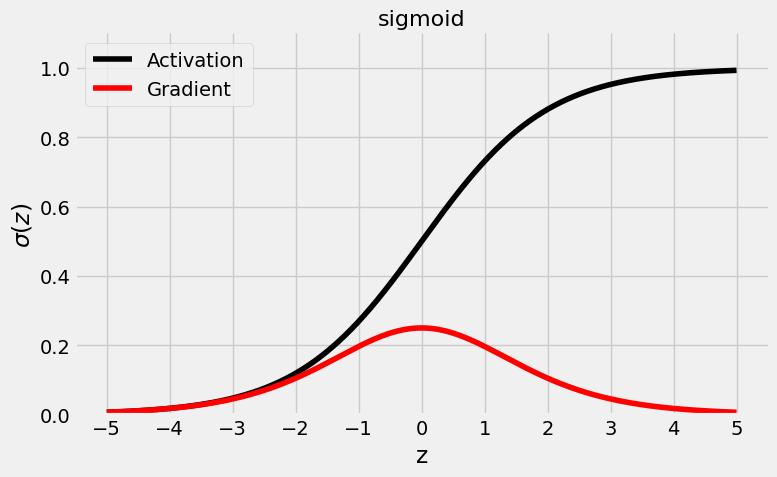

In [52]:
fig = plot_activation(torch.sigmoid)

In [53]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.sigmoid(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

In [54]:
nn.Sigmoid()(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

### Hyperbolic Tangent (Tanh)

$$
\Large \sigma(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}
$$

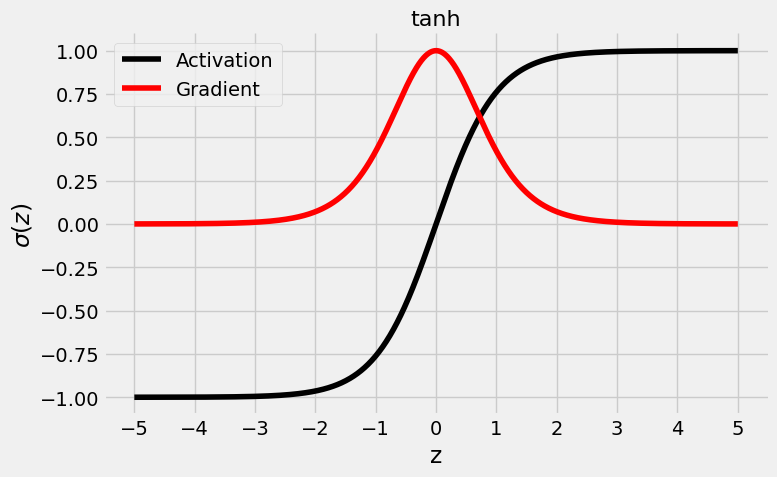

In [55]:
fig = plot_activation(torch.tanh)

In [56]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.tanh(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

In [57]:
nn.Tanh()(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

### Rectified Linear Unit (ReLU)

$$
\Large
\begin{aligned}
    \sigma(z) & = 
    \begin{cases}
    z, \ if \ z \ge 0
    \\
    0, \ if \ z < 0
    \end{cases}
    \\
    & or
    \\
    \sigma(z) & = max(0, z)
\end{aligned}
$$

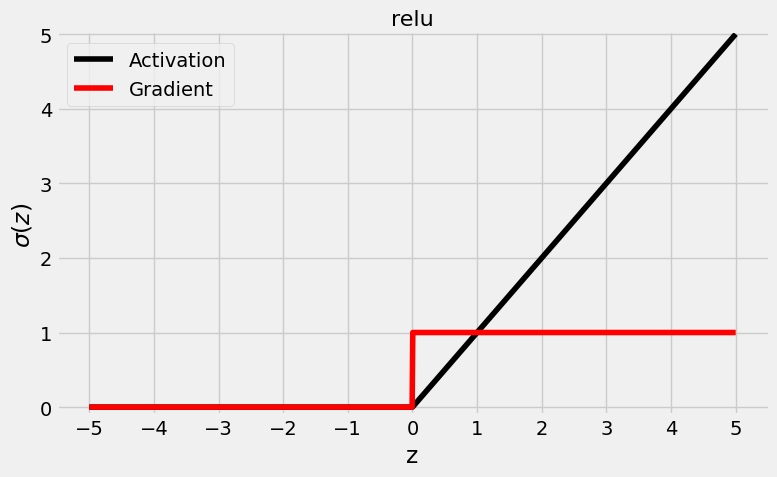

In [58]:
fig = plot_activation(torch.relu)

In [60]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.relu(dummy_z)

tensor([0., 0., 3.])

In [64]:
F.relu(dummy_z)

tensor([0., 0., 3.])

In [61]:
nn.ReLU()(dummy_z)

tensor([0., 0., 3.])

In [62]:
dummy_z.clamp(min=0)

tensor([0., 0., 3.])

### Leaky ReLU

$$
\Large
\begin{aligned}
    \sigma(z) & = 
    \begin{cases}
        z,\ if \ z \ge 0
        \\
        0.01z,\ if \ z < 0
    \end{cases}
    \\
    & or
    \\
    \sigma(z) & = max(0,\ z) + 0.01min(0,\ z)
\end{aligned}
$$

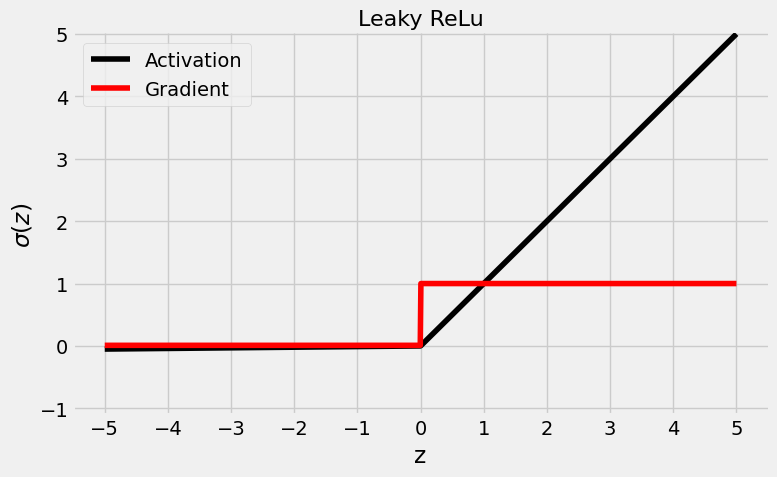

In [63]:
fig = plot_activation(nn.LeakyReLU(), name='Leaky ReLu')

In [65]:
dummy_z = torch.tensor([-3., 0., 3.])
F.leaky_relu(dummy_z, negative_slope=.01)

tensor([-0.0300,  0.0000,  3.0000])

In [66]:
nn.LeakyReLU(negative_slope=.02)(dummy_z)

tensor([-0.0600,  0.0000,  3.0000])

### Parametric ReLU (PReLU)

$$
\Large
\begin{aligned}
    \sigma(z) & = 
    \begin{cases}
        z,\ if \ z \ge 0
        \\
        az,\ if \ z < 0
    \end{cases}
    \\
    & or
    \\
    \sigma(z) & = max(0,\ z) + a\ min(0,\ z)
\end{aligned}
$$

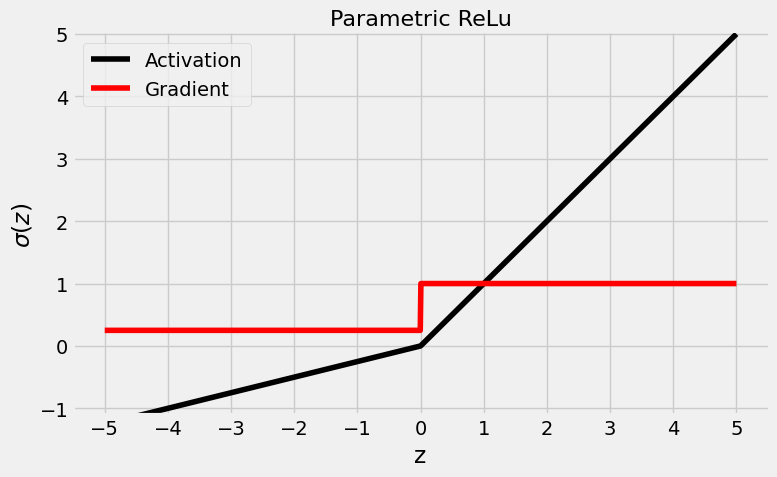

In [67]:
fig = plot_activation(nn.PReLU(), name='Parametric ReLu')

In [68]:
dummy_z = torch.tensor([-3., 0., 3.])
F.prelu(dummy_z, weight=torch.tensor(.25))

tensor([-0.7500,  0.0000,  3.0000])

In [69]:
nn.PReLU(init=.25)(dummy_z)

tensor([-0.7500,  0.0000,  3.0000], grad_fn=<PreluKernelBackward0>)

## Deep Model

![](images/classification_relu2.png)

### Model Configuration

In [70]:
lr = .1

torch.manual_seed(17)

model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

bce_loss_fn = nn.BCELoss()

### Model Training

In [71]:
n_epochs = 50

sbs_relu = StepByStep(model_relu, bce_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)

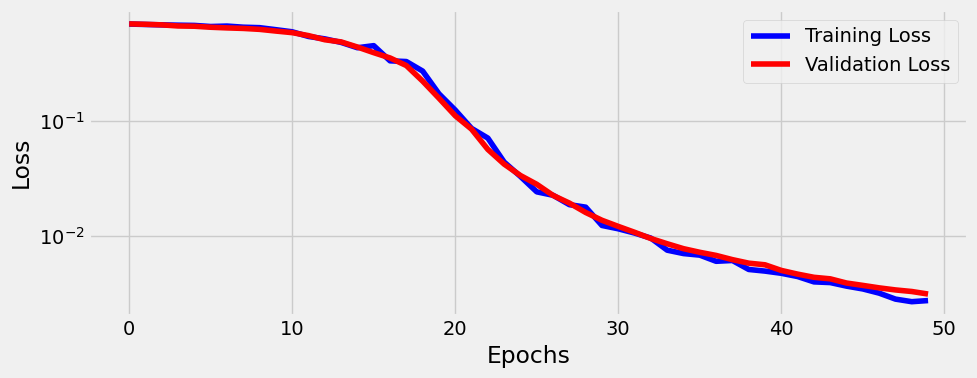

In [72]:
fig = sbs_relu.plot_losses()

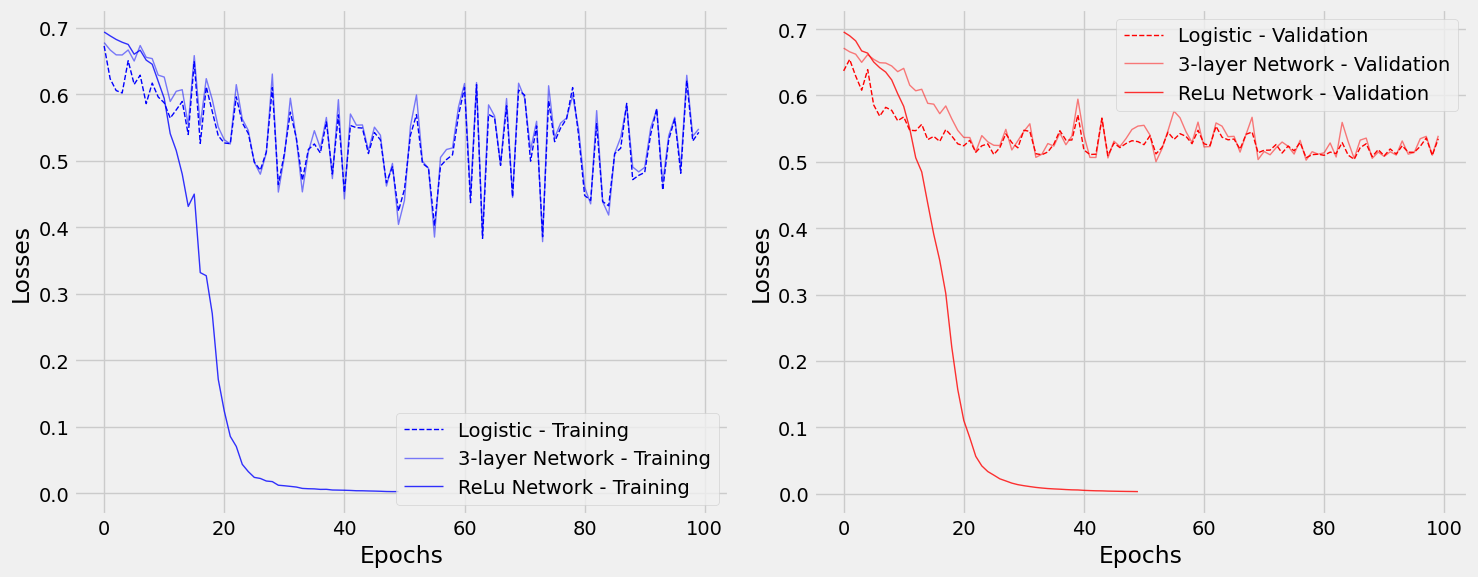

In [76]:
fig = figure5(sbs_logistic, sbs_nn, sbs_relu)

### Show Me the Math Again!

$$
\begin{array}{rcccccccccccc}
\text{Hidden }\#0 & & & & & & & &
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
&
=
&
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}
&
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
\text{Hidden }\#1 & & & &
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
&
=
&
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}
&
&
\underbrace{
f_0
\underset{(5 \times 1)}{
\left(
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}
\right)}}_{\text{Activation \#0}}
\\
\text{Output} &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}
&
\underbrace{
f_1
\underset{(3 \times 1)}{
\left(
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}
\right)}}_{\text{Activation \#1}}
\\
\hline
\text{substituting z's...} &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underbrace{
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}}_{\text{Output Layer}}
&
f_1
& &
\left(
\underbrace{
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}}_{\text{Hidden Layer \#1}}
\right.
&
&
f_0
& &
\left(
\underbrace{
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}}_{\text{Hidden Layer \#0}}
\right.
&
&
\left.
\left.
\underbrace{
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}}_{\text{Inputs}}
\right)
\right)
\end{array}
$$

## Putting It All Together

In [ ]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]

        if self.transform:
            x = self.transform(x)

        return x, self.y[index]

    def __len__(self):
        return len(self.x)

In [ ]:
def index_splitter(n, splits, seed=13):
    '''
    Parameters:
    n: The number of data points to generate indices for.
    splits: A list of values representing the relative weights of the split sizes.
    seed: A random seed to ensure reproducibility.
    '''

    idx = torch.arange(n)

    # Make the splits argument a tensor
    splits_tensor = torch.as_tensor(splits)
    total = splits_tensor.sum().float()

    # If the total does not add up to one, divide every number by the total.
    if not total.isclose(torch.tensor(1.)):
        splits_tensor = splits_tensor / total

    # Use PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

In [ ]:
def make_balanced_sampler(y):
    # Compute weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1. / counts.float()
    sample_weights = weights[y.squeeze().long()]

    generator = torch.Generator()

    # Build the weighted sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )

    return sampler

In [ ]:
# Build tensors from numpy arrays BEFORE split
# Modify the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Use index_splitter to generate indices for training and validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])

# Use indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Build different composers because of data augmentation on training set
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Use custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Build a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Use sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [ ]:
lr = .1

torch.manual_seed(17)

model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

bce_loss_fn = nn.BCELoss()

In [ ]:
n_epochs = 50

sbs_relu = StepByStep(model_relu, bce_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)